<a href="https://colab.research.google.com/github/SeungjaeHwang354/Exchange-rate-medeling-by-OU-Process/blob/main/Dbgaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[China] 처리 완료 ✅
[Eurozone] 처리 완료 ✅
[India] 처리 완료 ✅
[Japan] 처리 완료 ✅
[South Korea] 처리 완료 ✅
[Mexico] 처리 완료 ✅
[Philippines] 처리 완료 ✅
[Vietnam] 처리 완료 ✅


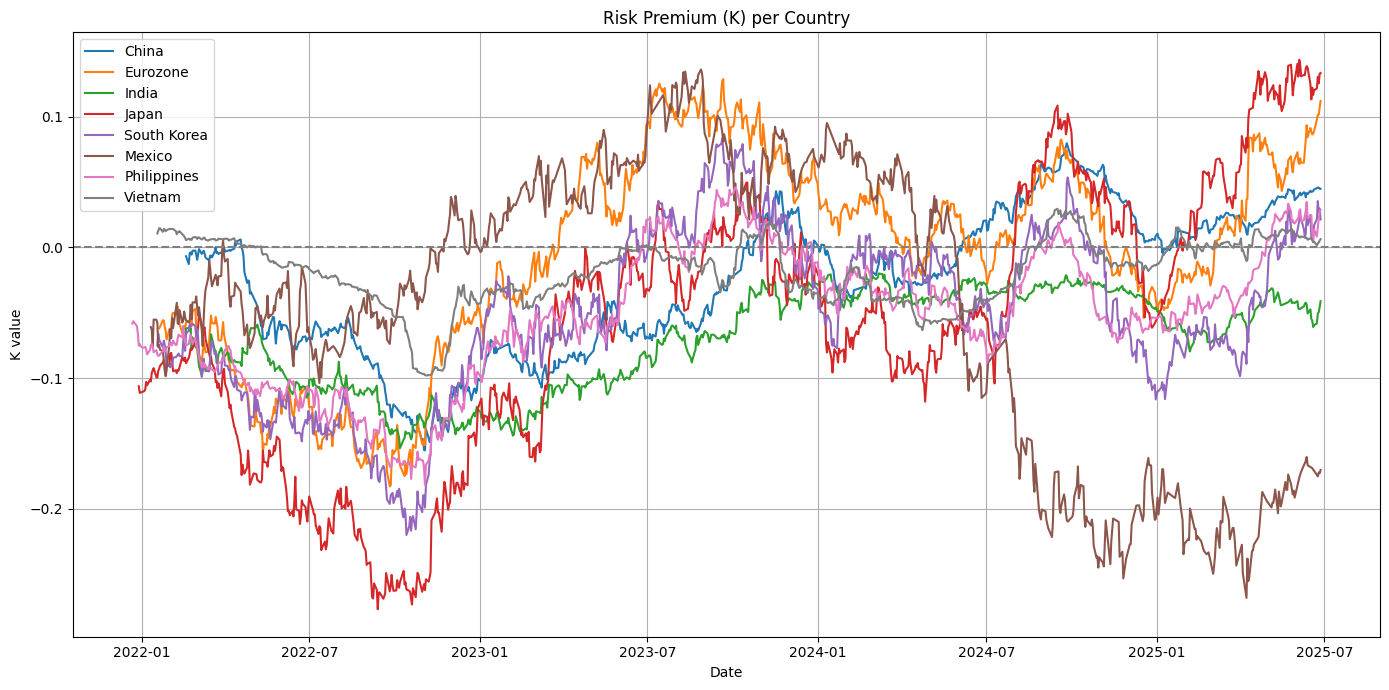

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 설정 ---
base_currency = "USD"
us_bond_file = "United States 1-Year Bond Yield Historical Data.csv"
days_in_year = 252

# --- 주요 국가 리스트 ---
countries = {
    "China": "CNY",
    "Eurozone": "EUR",
    "India": "INR",
    "Japan": "JPY",
    "South Korea": "KRW",
    "Mexico": "MXN",
    "Philippines": "PHP",
    "Vietnam": "VND"
}

# ✅ 보조 함수: 금리/환율 파일 자동 처리
def load_bond_data(filepath, target_col_name='rate'):
    df = pd.read_csv(filepath)
    date_col = [col for col in df.columns if 'Date' in col or '날짜' in col][0]
    value_col = [col for col in df.columns if 'Price' in col or '종가' in col][0]
    df['Date'] = pd.to_datetime(df[date_col].astype(str).str.strip(), errors='coerce')
    df[target_col_name] = df[value_col].astype(str).str.replace(",", "").astype(float)
    return df[['Date', target_col_name]]

def load_fx_data(filepath):
    df = pd.read_csv(filepath)
    date_col = [col for col in df.columns if 'Date' in col or '날짜' in col][0]
    value_col = [col for col in df.columns if 'Price' in col or '종가' in col][0]
    df['Date'] = pd.to_datetime(df[date_col].astype(str).str.strip(), errors='coerce')
    df['spot_rate'] = df[value_col].astype(str).str.replace(",", "").astype(float)
    return df[['Date', 'spot_rate']]

# ✅ 미국 금리 불러오기
us = load_bond_data(us_bond_file, target_col_name='us_rate')

# ✅ 결과 저장
all_k = []

for country, ticker in countries.items():
    try:
        fx_file = f"{ticker}_USD Historical Data.csv"
        bond_file = f"{country} 1-Year Bond Yield Historical Data.csv"

        if not os.path.exists(fx_file) or not os.path.exists(bond_file):
            print(f"[{country}] 파일 없음: {fx_file} 또는 {bond_file}")
            continue

        fx = load_fx_data(fx_file)
        local = load_bond_data(bond_file, target_col_name='local_rate')

        # 병합
        df = fx.merge(local, on='Date').merge(us, on='Date')
        df = df.dropna().sort_values('Date').reset_index(drop=True)

        # K 계산 (환율: XXX/USD 사용, IRP 적용)
        k_direct = []
        date_list = []

        for i in range(len(df) - days_in_year):
            s_now = df['spot_rate'].iloc[i]                   # XXX/USD
            s_future = df['spot_rate'].iloc[i + days_in_year] # 1년 후
            r_us = df['us_rate'].iloc[i]
            r_local = df['local_rate'].iloc[i]
            r_diff_now = (r_us - r_local) / 100               # IRP 기준: 미국 - 현지
            K_approx = np.log(s_future / s_now) + r_diff_now
            k_direct.append(K_approx)
            date_list.append(df['Date'].iloc[i + days_in_year])

        tmp_df = pd.DataFrame({
            'Date': date_list,
            'K': k_direct,
            'Country': country
        })

        all_k.append(tmp_df)
        print(f"[{country}] 처리 완료 ✅")

    except Exception as e:
        print(f"[{country}] 처리 중 오류 ❌: {e}")

# ✅ 통합 및 시각화
result = pd.concat(all_k).reset_index(drop=True)

plt.figure(figsize=(14, 7))
for country in result['Country'].unique():
    subset = result[result['Country'] == country]
    plt.plot(subset['Date'], subset['K'], label=country)

plt.axhline(0, color='gray', linestyle='--')
plt.title("Risk Premium (K) per Country")
plt.xlabel("Date")
plt.ylabel("K value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


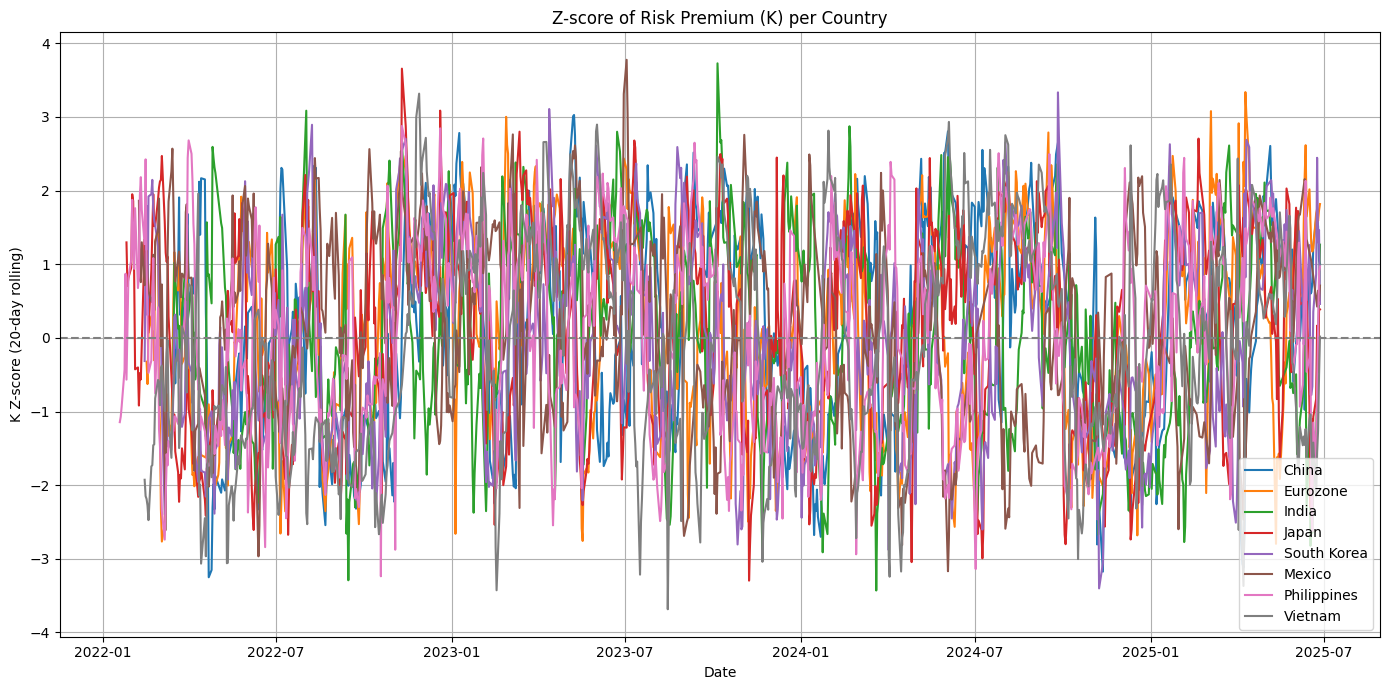

In [158]:
# ✅ 국가별 Z-score 계산
zscore_df = []

for country in result['Country'].unique():
    country_df = result[result['Country'] == country].copy()
    country_df = country_df.sort_values('Date').reset_index(drop=True)

    # rolling Z-score (20일 기준)
    country_df['K_zscore'] = (country_df['K'] - country_df['K'].rolling(20).mean()) / country_df['K'].rolling(20).std()
    zscore_df.append(country_df)

# 통합
zscore_result = pd.concat(zscore_df).reset_index(drop=True)

# ✅ 시각화
plt.figure(figsize=(14, 7))
for country in zscore_result['Country'].unique():
    subset = zscore_result[zscore_result['Country'] == country]
    plt.plot(subset['Date'], subset['K_zscore'], label=country)

plt.axhline(0, color='gray', linestyle='--')
plt.title("Z-score of Risk Premium (K) per Country")
plt.xlabel("Date")
plt.ylabel("K Z-score (20-day rolling)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [160]:
# Z-score 계산 (20일 이동 평균 및 표준편차 기준)
result = result.sort_values(['Country', 'Date']).reset_index(drop=True)
result['K_zscore'] = result.groupby('Country')['K'].transform(lambda x: (x - x.rolling(20).mean()) / x.rolling(20).std())

# 최근 10일치 추출
recent_10 = result.groupby('Country').tail(5)

# 보기 좋게 정렬
recent_10 = recent_10[['Date', 'Country', 'K', 'K_zscore']].sort_values(['Country', 'Date'])

# 출력
print(recent_10)


           Date      Country         K  K_zscore
800  2025-06-23        China  0.045266  1.615614
801  2025-06-24        China  0.045734  1.670512
802  2025-06-25        China  0.045731  1.515319
803  2025-06-26        China  0.044833  1.046835
804  2025-06-27        China  0.044839  1.005440
1679 2025-06-23     Eurozone  0.097653  1.693336
1680 2025-06-24     Eurozone  0.101585  1.750611
1681 2025-06-25     Eurozone  0.101724  1.590279
1682 2025-06-26     Eurozone  0.106951  1.733907
1683 2025-06-27     Eurozone  0.112148  1.817895
2482 2025-06-23        India -0.058245 -1.591573
2483 2025-06-24        India -0.050681 -0.357201
2484 2025-06-25        India -0.049594 -0.130617
2485 2025-06-26        India -0.045839  0.522816
2486 2025-06-27        India -0.041199  1.266573
3358 2025-06-23        Japan  0.121715 -0.828426
3359 2025-06-24        Japan  0.130490  0.166281
3360 2025-06-25        Japan  0.125566 -0.467657
3361 2025-06-26        Japan  0.133005  0.372887
3362 2025-06-27     

[China] 처리 완료 ✅
[Eurozone] 처리 완료 ✅
[India] 처리 완료 ✅
[Japan] 처리 완료 ✅
[South Korea] 처리 완료 ✅
[Mexico] 처리 완료 ✅
[Philippines] 처리 완료 ✅
[Vietnam] 처리 완료 ✅


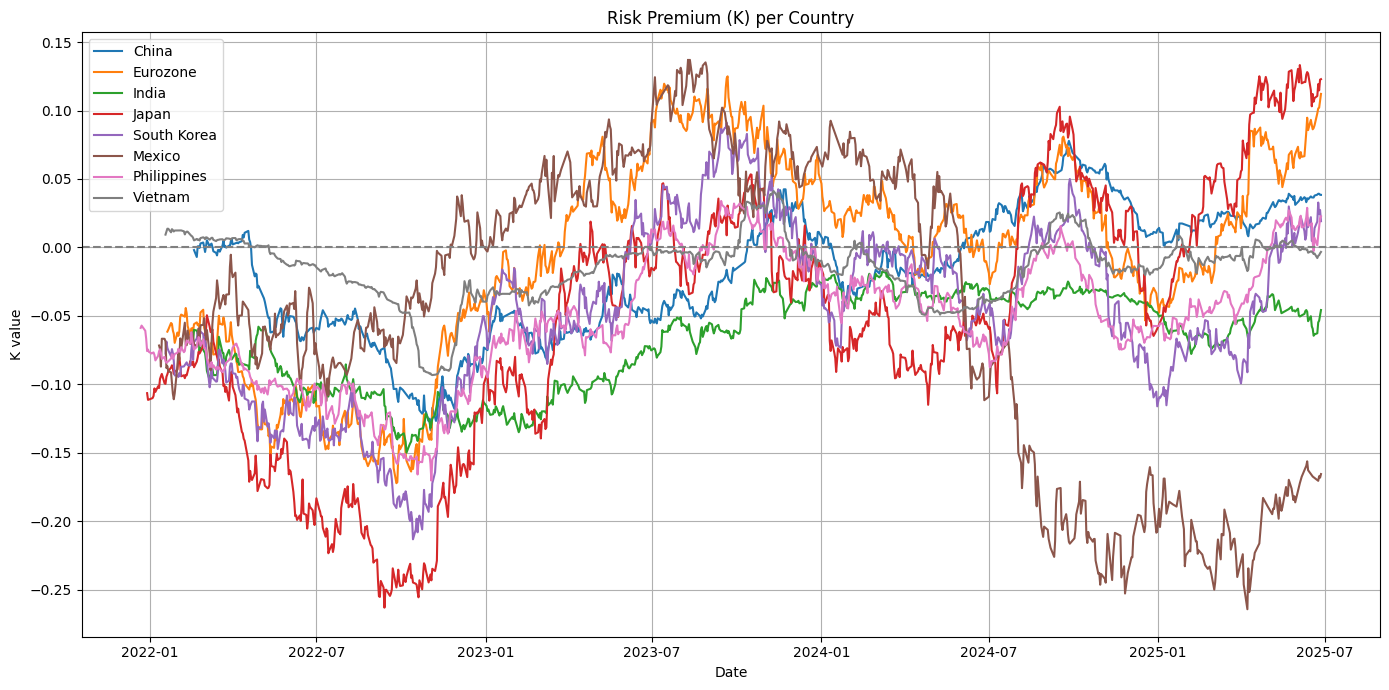

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 설정 ---
base_currency = "USD"
us_bond_file = "United States 1-Year Bond Yield Historical Data.csv"
days_in_year = 252

# --- 주요 국가 리스트 ---
countries = {
    "China": "CNY",
    "Eurozone": "EUR",
    "India": "INR",
    "Japan": "JPY",
    "South Korea": "KRW",
    "Mexico": "MXN",
    "Philippines": "PHP",
    "Vietnam": "VND"
}

# ✅ 보조 함수: 금리/환율 파일 자동 처리
def load_bond_data(filepath, target_col_name='rate'):
    df = pd.read_csv(filepath)
    date_col = [col for col in df.columns if 'Date' in col or '날짜' in col][0]
    value_col = [col for col in df.columns if 'Price' in col or '종가' in col][0]
    df['Date'] = pd.to_datetime(df[date_col].astype(str).str.strip(), errors='coerce')
    df[target_col_name] = df[value_col].astype(str).str.replace(",", "").astype(float)
    return df[['Date', target_col_name]]

def load_fx_data(filepath):
    df = pd.read_csv(filepath)
    date_col = [col for col in df.columns if 'Date' in col or '날짜' in col][0]
    value_col = [col for col in df.columns if 'Price' in col or '종가' in col][0]
    df['Date'] = pd.to_datetime(df[date_col].astype(str).str.strip(), errors='coerce')
    df['spot_rate'] = df[value_col].astype(str).str.replace(",", "").astype(float)
    return df[['Date', 'spot_rate']]

# ✅ 미국 금리 불러오기
us = load_bond_data(us_bond_file, target_col_name='us_rate')

# ✅ 결과 저장
all_k = []

for country, ticker in countries.items():
    try:
        fx_file = f"{ticker}_USD Historical Data.csv"
        bond_file = f"{country} 1-Year Bond Yield Historical Data.csv"

        if not os.path.exists(fx_file) or not os.path.exists(bond_file):
            print(f"[{country}] 파일 없음: {fx_file} 또는 {bond_file}")
            continue

        fx = load_fx_data(fx_file)
        local = load_bond_data(bond_file, target_col_name='local_rate')

        # 병합
        df = fx.merge(local, on='Date').merge(us, on='Date')
        df = df.dropna().sort_values('Date').reset_index(drop=True)

# K 계산 (1년간 누적 금리 차이 반영)
        k_direct = []
        date_list = []

        for i in range(len(df) - days_in_year):
            s_now = df['spot_rate'].iloc[i]
            s_future = df['spot_rate'].iloc[i + days_in_year]

    # 1년치 금리 차이 평균
            r_us_slice = df['us_rate'].iloc[i:i + days_in_year]
            r_local_slice = df['local_rate'].iloc[i:i + days_in_year]
            avg_r_diff = ((r_us_slice - r_local_slice).mean()) / 100  # 연율 % → 비율

    # 누적 IRP 수익률과 비교한 K 계산
            K_approx = np.log(s_future / s_now) + avg_r_diff
            k_direct.append(K_approx)
            date_list.append(df['Date'].iloc[i + days_in_year])

        tmp_df = pd.DataFrame({
            'Date': date_list,
            'K': k_direct,
            'Country': country
        })

        all_k.append(tmp_df)
        print(f"[{country}] 처리 완료 ✅")

    except Exception as e:
        print(f"[{country}] 처리 중 오류 ❌: {e}")

# ✅ 통합 및 시각화
result = pd.concat(all_k).reset_index(drop=True)

plt.figure(figsize=(14, 7))
for country in result['Country'].unique():
    subset = result[result['Country'] == country]
    plt.plot(subset['Date'], subset['K'], label=country)

plt.axhline(0, color='gray', linestyle='--')
plt.title("Risk Premium (K) per Country")
plt.xlabel("Date")
plt.ylabel("K value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  8 of 8 completed


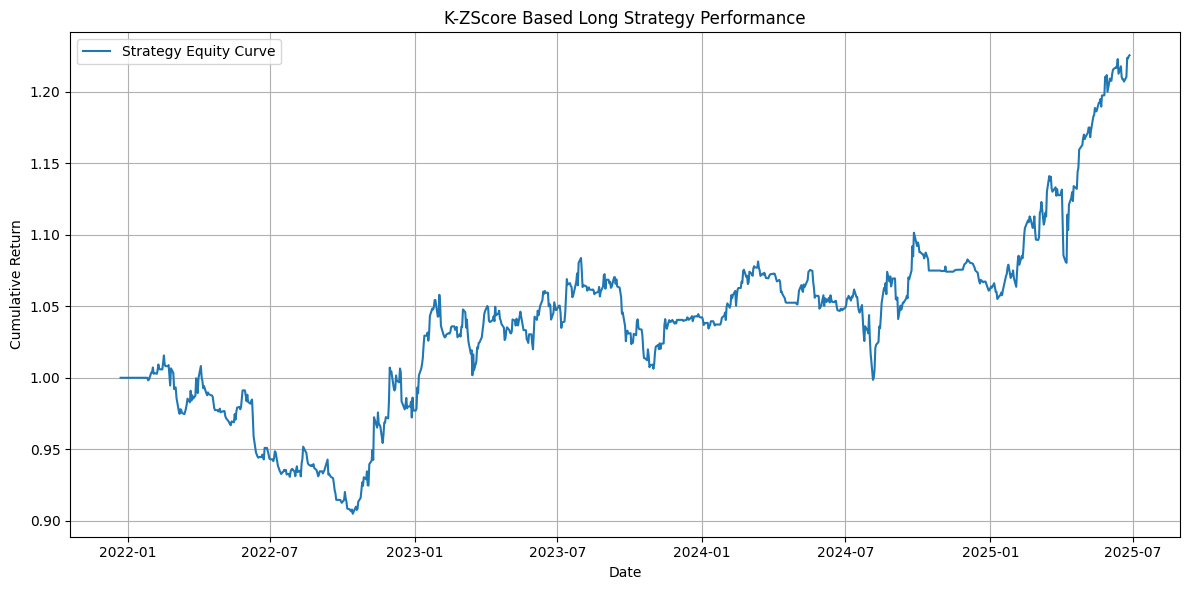

In [141]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# 예시 데이터를 불러왔다고 가정: result에는 'Date', 'K', 'Country' 컬럼이 있음
# 실제 환경에서는 result = pd.read_csv(...) 혹은 위에서 만든 result DataFrame 사용
# 여기서는 임의의 구조로 시뮬레이션

# 가정: 각 국가별 ETF 심볼 정의 (Yahoo Finance 기준)
etf_tickers = {
    "China": "MCHI",        # iShares MSCI China ETF
    "Eurozone": "EZU",      # iShares MSCI Eurozone ETF
    "India": "INDA",        # iShares MSCI India ETF
    "Japan": "EWJ",         # iShares MSCI Japan ETF
    "South Korea": "EWY",   # iShares MSCI South Korea ETF
    "Mexico": "EWW",        # iShares MSCI Mexico ETF
    "Philippines": "EPHE",  # iShares MSCI Philippines ETF
    "Vietnam": "VNM"        # VanEck Vietnam ETF
}

# 날짜 범위 설정
start_date = "2020-01-01"
end_date = "2025-06-30"

# ETF 가격 다운로드
prices = yf.download(list(etf_tickers.values()), start=start_date, end=end_date)["Close"]

# K 데이터프레임을 시간순 정렬
result['Date'] = pd.to_datetime(result['Date'])
result = result.sort_values('Date')


# 국가별 Z-Score 계산 및 포지션 결정
positions = []
for country in result['Country'].unique():
    country_df = result[result['Country'] == country].copy()
    country_df = country_df.sort_values('Date').reset_index(drop=True)

    # Z-Score 계산 (window=10일)
    country_df['K_zscore'] = (country_df['K'] - country_df['K'].rolling(20).mean()) / country_df['K'].rolling(20).std()

    # 초기 포지션 0
    position = [0]

    # 롱-중립 전략
    for i in range(1, len(country_df)):
        z = country_df.loc[i, 'K_zscore']
        prev = position[-1]

        if z > 0.5:
            position.append(1)
        elif z <-0.5:
            position.append(0)
        else:
            position.append(prev)  # 이전 포지션 유지

    country_df['Position'] = position
    country_df['Ticker'] = etf_tickers[country]
    positions.append(country_df[['Date', 'Ticker', 'Position']])

# 포지션 통합
position_df = pd.concat(positions)
pivot_position = position_df.pivot(index='Date', columns='Ticker', values='Position').fillna(0)

# 리턴 계산
returns = prices.pct_change().reindex(pivot_position.index).fillna(0)
strategy_returns = (pivot_position.shift(1) * returns).mean(axis=1)  # equal weight

# 누적 수익률 계산
cumulative_returns = (1 + strategy_returns).cumprod()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label="Strategy Equity Curve")
plt.title("K-ZScore Based Long Strategy Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


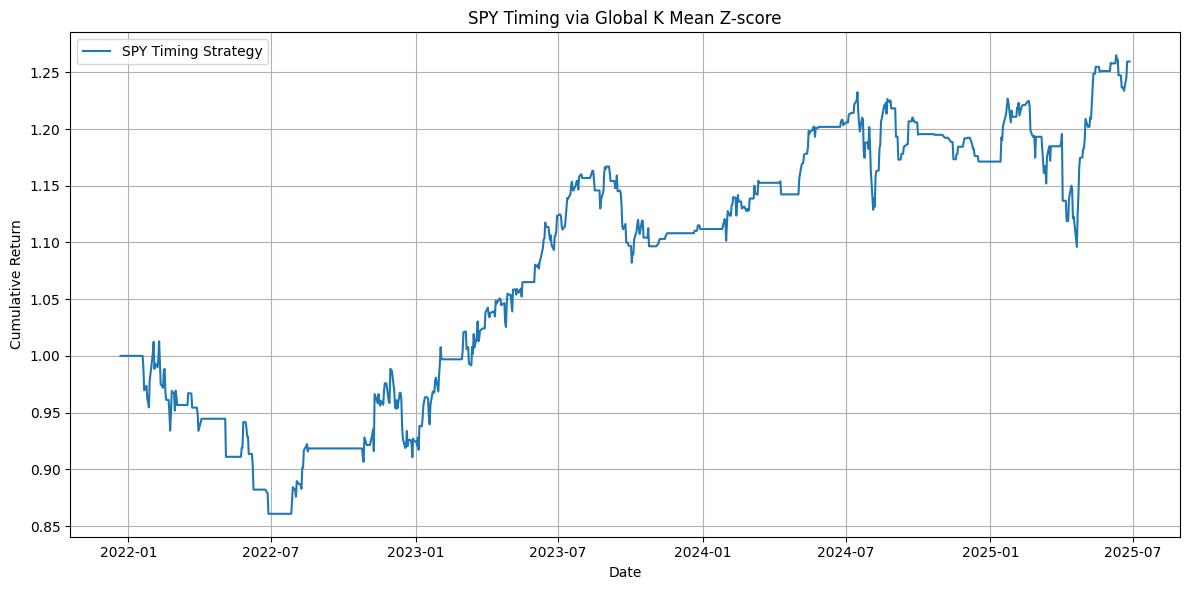

In [153]:
spy = yf.download("SPY", start=start_date, end=end_date)["Close"]
if isinstance(spy, pd.DataFrame):
    spy = spy.squeeze()

k_mean = result.groupby("Date")["K"].mean().dropna()
k_mean_z = (k_mean - k_mean.rolling(20).mean()) / k_mean.rolling(20).std()

position = []
prev = 0
for z in k_mean_z:
    if z >0:
        position.append(1)
        prev = 1
    elif z  <0:
        position.append(0)
        prev = 0
    else:
        position.append(prev)

timing_df = pd.DataFrame({
    'Date': k_mean.index,
    'Zscore': k_mean_z,
    'Position': position
}).set_index('Date')

spy_returns = spy.pct_change().reindex(timing_df.index).fillna(0)
timing_df['Strategy Return'] = spy_returns * timing_df['Position'].shift(1).fillna(0)
timing_df['Cumulative'] = (1 + timing_df['Strategy Return']).cumprod()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(timing_df.index, timing_df['Cumulative'], label="SPY Timing Strategy")
plt.title("SPY Timing via Global K Mean Z-score")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


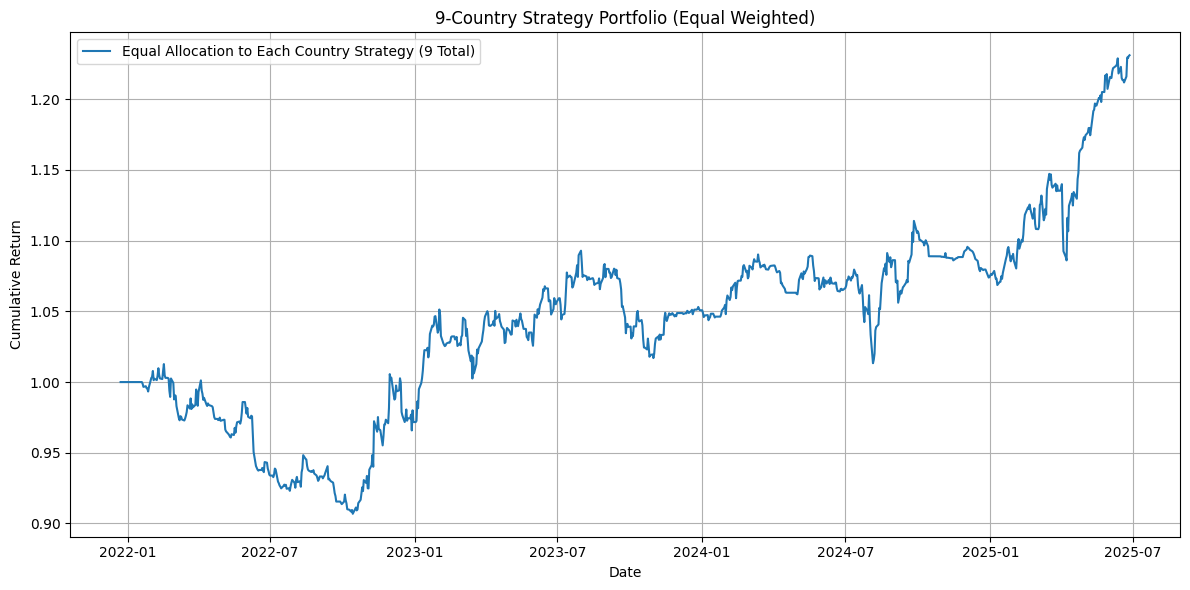

In [146]:
# 모든 ETF + SPY 가격
all_prices = prices.copy()
all_prices['SPY'] = spy

# 수익률 계산
returns = all_prices.pct_change().fillna(0)

# 기존 ETF 포지션
pivot_position = position_df.pivot(index='Date', columns='Ticker', values='Position').fillna(0)

# SPY 포지션 추가
spy_pos = timing_df['Position'].reindex(pivot_position.index).fillna(0)
pivot_position['SPY'] = spy_pos

# 날짜 정렬
returns = returns.reindex(pivot_position.index).fillna(0)

# 전략 수익률 계산: 각 전략의 (position × return)
individual_returns = pivot_position.shift(1) * returns

# ✅ 항상 모든 전략을 동일비중(1/9)으로 보유
portfolio_returns = individual_returns.mean(axis=1)

# 누적 수익률
cumulative_returns = (1 + portfolio_returns).cumprod()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label="Equal Allocation to Each Country Strategy (9 Total)")
plt.title("9-Country Strategy Portfolio (Equal Weighted)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


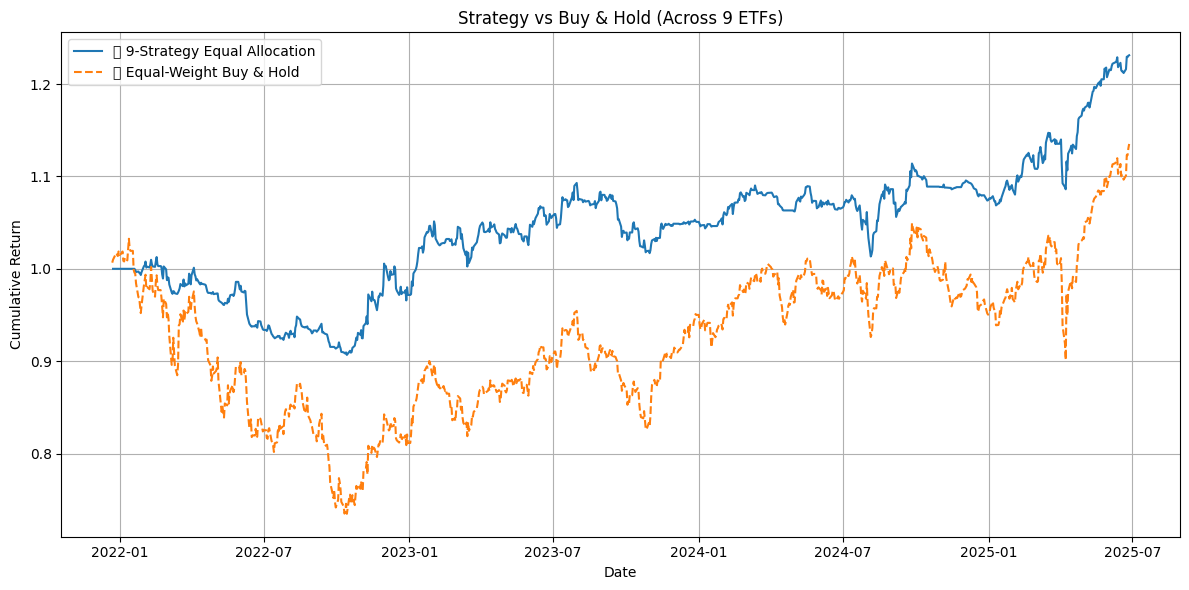

In [147]:
# === Equal-weight Buy & Hold 전략 (항상 1/N 비중 유지) ===
buy_hold_returns = returns[list(pivot_position.columns)].mean(axis=1)
buy_hold_cumulative = (1 + buy_hold_returns).cumprod()

# === 전략 누적 수익률 ===
strategy_cumulative = (1 + portfolio_returns).cumprod()

# === 시각화 ===
plt.figure(figsize=(12, 6))
plt.plot(strategy_cumulative.index, strategy_cumulative, label="📊 9-Strategy Equal Allocation")
plt.plot(buy_hold_cumulative.index, buy_hold_cumulative, linestyle='--', label="📦 Equal-Weight Buy & Hold")
plt.title("Strategy vs Buy & Hold (Across 9 ETFs)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
K-ZScore 9-Strategy,0.059477,0.082779,0.718509,-0.104554
Buy & Hold (Equal Weighted),0.035845,0.157522,0.227558,-0.288305


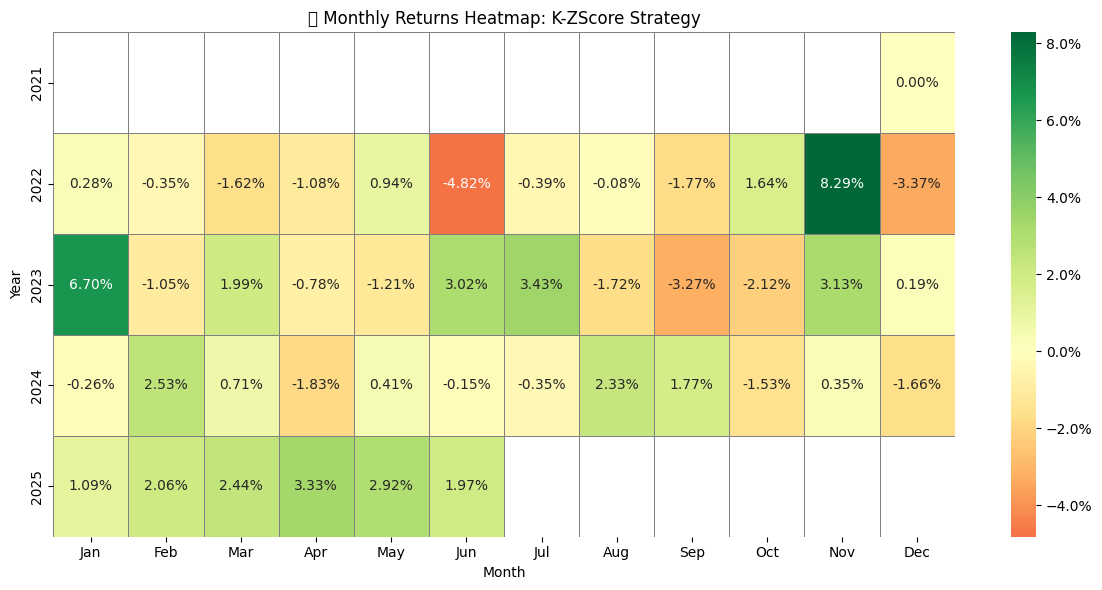

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 수익률: 전략 vs Buy & Hold ===
strategy_daily_ret = portfolio_returns.copy()         # 9-전략 포트폴리오 수익률
buy_hold_daily_ret = buy_hold_returns.copy()          # 단순 equal-weight buy & hold 수익률

# === 성과지표 계산 함수 ===
def compute_metrics(returns, name, rf=0.0):
    ann_return = np.power((1 + returns).prod(), 252 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = (ann_return - rf) / ann_vol
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    return pd.Series({
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }, name=name)

# === 통계 요약표 ===
comparison_stats = pd.concat([
    compute_metrics(strategy_daily_ret, "K-ZScore 9-Strategy"),
    compute_metrics(buy_hold_daily_ret, "Buy & Hold (Equal Weighted)")
], axis=1)

display(comparison_stats.T)

# === 월별 수익률 히트맵 ===
monthly_returns = pd.DataFrame({
    "K-ZScore Strategy": strategy_daily_ret,
    "Buy & Hold": buy_hold_daily_ret
}).resample('M').apply(lambda x: (1 + x).prod() - 1)

k_monthly = monthly_returns["K-ZScore Strategy"].to_frame()
k_monthly['Year'] = k_monthly.index.year
k_monthly['Month'] = k_monthly.index.strftime('%b')
k_pivot = k_monthly.pivot(index='Year', columns='Month', values='K-ZScore Strategy')

# 월 순서 정렬
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
k_pivot = k_pivot[month_order]

# 히트맵 시각화
import seaborn as sns
import matplotlib.ticker as mticker

plt.figure(figsize=(12, 6))
sns.heatmap(k_pivot, annot=True, fmt=".2%", cmap="RdYlGn", center=0,
            linewidths=0.5, linecolor='gray', cbar_kws={'format': mticker.PercentFormatter(1.0)})
plt.title("📅 Monthly Returns Heatmap: K-ZScore Strategy")
plt.ylabel("Year")
plt.xlabel("Month")
plt.tight_layout()
plt.show()
